<h1 align=center><font size = 5>Capstone Project - The Battle of the Neighborhoods</font></h1>

## Applied Data Science Capstone by IBM/Coursera

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Introduction: Business Problem](#0)<br>
2. [Data](#2)<br>
3. [Methodology](#4) <br>
4. [Results and Discussion ](#6) <br>
5. [Conclusion](#8) <br>
</div>
<hr>

## Introduction: Business Problem

The goal of this project is to help anybody who doesn't know Paris and would like to buy a house or an apartment with somehow the best possible value for money. Indeed, in Paris, like any big city, you have many very different neighborhoods; each of them has its advantages and disadvantages so it is hard to find the best place to live especially if you don't know already the city.

In this project, I will consider that a good place to live, is a place located near at least one subway station and as many venues as possible because I want a dynamic place with a lot of activities around it and all this for the lowest possible price.


## Data

To fulfill the requirements of this project, I will need several data sources:
* https://opendata.paris.fr to get the shape of Paris and its boroughs, it will be used to filter and better locate the potential locations.
* http://dataratp.download.opendatasoft.com to retrieve the positions of all existing subway stations, it will be used to keep only the locations close to one of them.
* https://cadastre.data.gouv.fr to have all the transactions of houses or apartments in Paris since 2014, it will be used to get the average price by square meter and to keep potential locations where there are enough transactions.
* https://api.foursquare.com to get all the venues close to each potential location.
* https://nominatim.openstreetmap.org to retrieve the addresses corresponding to the final potential locations.




## Methodology

The first thing to do is to import everything that will be needed in this notebook.

In [1]:
import numpy as np
import pandas as pd
import requests
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.10.0 --yes
from geopy.distance import geodesic
import math
import folium
!conda install -c conda-forge shapely --yes 
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from folium import plugins
from folium.plugins import HeatMap
import requests
import zipfile
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         238 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0        conda-forge
    geopy:         1.20.0-py_0      conda-forge

The following pac

---

Throughout this notebook, I will consider that something is close to a given location if it is located within 200 meters. 

So let's first fix the value of the variable *maxRadius* representing this distance.

In [5]:
maxRadius = 200

Now, let's retrieve the geographic coordinates of Paris thanks to **geopy**

In [6]:
geolocator = Nominatim(user_agent='capstone')
location = geolocator.geocode("Paris")
paris_center = [location.latitude, location.longitude]
print("latitude=", paris_center[0], "longitude=",paris_center[1])

latitude= 48.8566101 longitude= 2.3514992


Let's now retrieve the shape of Paris and its boroughs

In [8]:
paris_boroughs_url = 'https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin'
paris_boroughs = requests.get(paris_boroughs_url).json()

def boroughs_style(feature):
    return { 'color': 'black', 'fill': True, 'fill_opacity': 0.4}

We can now display the map of Paris and its boroughs

In [6]:
map_paris = folium.Map(location=paris_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_paris) #cartodbpositron cartodbdark_matter
for feature in paris_boroughs["features"]:
    folium.Marker(
        location=feature["properties"]["geom_x_y"],
        popup=feature["properties"]["l_ar"],
        icon=folium.Icon(color='green')
    ).add_to(map_paris)
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
map_paris

Now, I need to identify all the potential locations to study. 

For that: 
1. I need to define the rectangle that contains entirely Paris by getting the minimum and maximum latitude and longitude
1. Then I find the middle of that rectangle
1. From that middle, I compute the distance between the middle and the top-right edge of the rectangle, this distance is the radius of the circle that will contain the rectangle.
1. Finally I check if this distance is equal to or below 200 meters if so I keep this middle as a potential location, otherwise, I split the  rectangle into 4 rectangles (top left, top right, bottom right, and bottom left) and I go back to step #2

If I strictly apply the algorithm described previously, I will get **4096** potential locations that actually cover the entire rectangle which contains Paris but as Paris is not a rectangle, most of them are outside the city, so at step #4, I add an extra filter to keep only the locations that are inside the city. Thanks to this filter, I end up with **2487** potential locations in the **20** boroughs of Paris.

In [7]:
minLatitude = float('inf')
maxLatitude = float('-inf')
minLongitude = float('inf')
maxLongitude = float('-inf')

for feature in paris_boroughs["features"]:
    for coordinates in feature["geometry"]["coordinates"][0]:
        if (coordinates[1] < minLatitude):
            minLatitude = coordinates[1]
        if (coordinates[1] > maxLatitude):
            maxLatitude = coordinates[1]
        if (coordinates[0] < minLongitude):
            minLongitude = coordinates[0]
        if (coordinates[0] > maxLongitude):
            maxLongitude = coordinates[0]
centerLatitude = (maxLatitude + minLatitude) / 2
centerLongitude = (maxLongitude + minLongitude) / 2

polygons = []
for feature in paris_boroughs["features"]:
    polygons.append(Polygon(feature["geometry"]["coordinates"][0]))
print("Found", len(polygons), "boroughs in paris")
    
def is_in_paris(centerLatitude, centerLongitude):
    point = Point(centerLongitude, centerLatitude)
    for polygon in polygons:
        if (polygon.contains(point)):
            return True
    return False


def add_centers(centers, centerLatitude, centerLongitude, minLatitude, maxLatitude, minLongitude, maxLongitude, maxRadius):
    height = geodesic((minLatitude, centerLongitude), (maxLatitude, centerLongitude)).meters
    width = geodesic((centerLatitude, minLongitude), (centerLatitude, maxLongitude)).meters
    radius = math.sqrt((height/2)**2 + (width/2)**2)
    if radius <= maxRadius :
        if is_in_paris(centerLatitude, centerLongitude):
            centers.append([centerLatitude, centerLongitude])
    else :
        # slip in 4 centers
        # Upper right
        add_centers(centers, (centerLatitude + maxLatitude) / 2, (centerLongitude + maxLongitude) / 2, centerLatitude, maxLatitude, centerLongitude, maxLongitude, maxRadius)
        # Upper left
        add_centers(centers, (centerLatitude + maxLatitude) / 2, (centerLongitude + minLongitude) / 2, centerLatitude, maxLatitude, minLongitude, centerLongitude, maxRadius)
        # Lower right
        add_centers(centers, (centerLatitude + minLatitude) / 2, (centerLongitude + maxLongitude) / 2, minLatitude, centerLatitude, centerLongitude, maxLongitude, maxRadius)
        # Lower left
        add_centers(centers, (centerLatitude + minLatitude) / 2, (centerLongitude + minLongitude) / 2, minLatitude, centerLatitude, minLongitude, centerLongitude, maxRadius)

centers = []
add_centers(centers, centerLatitude, centerLongitude, minLatitude, maxLatitude, minLongitude, maxLongitude, maxRadius)
df_centers = pd.DataFrame(centers, columns = ['latitude', 'longitude'])
print("Found",df_centers.shape[0],"centers")

Found 20 boroughs in paris
Found 2487 centers


Let's have a look at the potential locations on the map of Paris

In [8]:
map_paris = folium.Map(location=paris_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_paris) #cartodbpositron cartodbdark_matter
for feature in paris_boroughs["features"]:
    folium.Marker(
        location=feature["properties"]["geom_x_y"],
        popup=feature["properties"]["l_ar"],
        icon=folium.Icon(color='green')
    ).add_to(map_paris)
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
for center in df_centers.values.tolist():
    folium.Circle(center, radius=maxRadius, color='blue', fill=True, fill_opacity=0.1).add_to(map_paris)
map_paris

As you can see on the map above, Paris is fully covered by the potential locations but I still need to reduce them by keeping only those which have at least one subway station nearby. 

So now, I need to retrieve all the subway stations.

In [9]:
!wget -q -O 'RATP_GTFS_LINES.zip' http://dataratp.download.opendatasoft.com/RATP_GTFS_LINES.zip
paris_subway_station_df = pd.DataFrame()
with zipfile.ZipFile('RATP_GTFS_LINES.zip') as zip:
    for zipfileName in zip.namelist():
        if zipfileName.startswith("RATP_GTFS_METRO_") and zipfileName.endswith('.zip') and zipfileName != 'RATP_GTFS_METRO_Fun.zip' and zipfileName != 'RATP_GTFS_METRO_Orv.zip':
            zip.extract(zipfileName)
            with zipfile.ZipFile(zipfileName) as innerZip:
                with innerZip.open('stops.txt') as myZip:
                    paris_subway_station_df = paris_subway_station_df.append(pd.read_csv(myZip), sort=False)
print("Data Downloaded")

Data Downloaded


Once I have loaded the data, I have to clean it to keep only what I need.

So I:
1. Keep only the columns that I need which are the name, the latitude, and longitude
1. Rename the columns to have more explicit names
1. Remove all the duplicates to keep only the first occurrence
1. Sort them by name (this step is not mandatory but it makes the list easier to read)

In [10]:
paris_subway_station_df = paris_subway_station_df[['stop_name', 'stop_lat', 'stop_lon']]
paris_subway_station_df.rename(columns={'stop_name': 'name', 'stop_lat': 'latitude', 'stop_lon': 'longitude'}, inplace=True)
paris_subway_station_df.drop_duplicates(subset='name', keep = 'first', inplace = True)
paris_subway_station_df.sort_values('name', inplace = True)
paris_subway_station_df

name   latitude  longitude
18                                           Abbesses  48.884400   2.338399
19                                    Alexandre-Dumas  48.856408   2.394500
7                                        Alma-Marceau  48.864299   2.301251
25                                             Alésia  48.828066   2.326827
7                                      Anatole-France  48.892019   2.285517
..                                                ...        ...        ...
0   Villejuif-Paul Vaillant Couturier (Hôpital Pau...  48.795994   2.368231
12                                           Villiers  48.881324   2.316597
13                                        Volontaires  48.841418   2.307994
17                               Voltaire (Léon Blum)  48.857664   2.380036
14                                             Wagram  48.883712   2.305558

[302 rows x 3 columns]

Let's display them on the map of Paris

In [11]:
map_paris = folium.Map(location=paris_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_paris) #cartodbpositron cartodbdark_matter
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
for index, row in paris_subway_station_df.iterrows():
    folium.CircleMarker([row["latitude"], row["longitude"]], popup=row["name"].replace("'", "&#39;"), radius=3, color='grey', fill=True, fill_color='blue', fill_opacity=1).add_to(map_paris)
map_paris

In [12]:
def is_in_circle(centerLatitude, centerLongitude, latitude, longitude, maxDistance):
    return True if geodesic((centerLatitude, centerLongitude), (latitude, longitude)).meters <= maxDistance else False

From here, I will simply iterate over all the potential locations and count how many subway stations there are nearby.

In [13]:
subwayStations = []
for i, rowCenters in df_centers.iterrows():
    total = 0
    centerLatitude = rowCenters["latitude"]
    centerLongitude = rowCenters["longitude"]
    for j, rowStations in paris_subway_station_df.iterrows():
        if is_in_circle(centerLatitude, centerLongitude, rowStations["latitude"], rowStations["longitude"], maxRadius):
            total = total + 1
    subwayStations.append(total)
    print(' {}'.format(total), end='')
print(' done.')    
df_centers["stations"] = subwayStations
df_centers.to_csv("df_centers.csv")
df_centers

 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 2 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 2 0 0 1 1 1 2 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 2 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 2 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 1 2 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 2 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 2 2 1 2 0 0 2 0 1 1 0 1 0 0 0 0 0 0 1 1 2 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0

latitude  longitude  stations
0     48.897427   2.394905         0
1     48.901485   2.387227         0
2     48.900133   2.391066         0
3     48.900133   2.387227         0
4     48.901485   2.383388         0
...         ...        ...       ...
2482  48.829782   2.272063         0
2483  48.828429   2.272063         0
2484  48.831135   2.268225         0
2485  48.829782   2.268225         0
2486  48.828429   2.268225         0

[2487 rows x 3 columns]

In [14]:
df_centers = pd.read_csv("df_centers.csv")
df_centers = df_centers[["latitude", "longitude", "stations"]]
df_centers

latitude  longitude  stations
0     48.897427   2.394905         0
1     48.901485   2.387227         0
2     48.900133   2.391066         0
3     48.900133   2.387227         0
4     48.901485   2.383388         0
...         ...        ...       ...
2482  48.829782   2.272063         0
2483  48.828429   2.272063         0
2484  48.831135   2.268225         0
2485  48.829782   2.268225         0
2486  48.828429   2.268225         0

[2487 rows x 3 columns]

I can now, keep only the potential locations that have at least one subway station nearby, which allows us to keep only **681** potential locations.

In [15]:
df_centers = df_centers[df_centers["stations"] > 0]
df_centers

latitude  longitude  stations
9     48.898780   2.387227         1
11    48.897427   2.387227         1
14    48.897427   2.383388         1
21    48.896074   2.387227         1
24    48.896074   2.383388         1
...         ...        ...       ...
2423  48.823018   2.325806         1
2425  48.821665   2.325806         1
2456  48.836547   2.279741         1
2458  48.835194   2.279741         1
2476  48.836547   2.256708         1

[681 rows x 3 columns]

Let's display them with the subway stations on a map

In [16]:
map_paris = folium.Map(location=paris_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_paris) #cartodbpositron cartodbdark_matter
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
for i, row in paris_subway_station_df.iterrows():
    folium.CircleMarker([row["latitude"], row["longitude"]], popup=row["name"].replace("'", "&#39;"), radius=3, color='grey', fill=True, fill_color='blue', fill_opacity=1).add_to(map_paris)
for center in df_centers.values.tolist():
    folium.Circle(center[0:2], radius=maxRadius, color='blue', fill=True, fill_opacity=0.1).add_to(map_paris)
map_paris

At this stage, I can still have some potential locations that don't make sense as they could be located far from the houses.

To fix this issue, I will load all the transactions in Paris for the past 5 years. I assume that if no transaction has occurred near a potential location, it would mean that there is no house to buy/sell, so it could not be a good candidate.

In [17]:
years = [2014, 2015, 2016, 2017, 2018]
paris_housing_sales_prices_df = pd.DataFrame()
for year in years:
    get_ipython().system("wget -q -O '{}-75.csv.gz' https://cadastre.data.gouv.fr/data/etalab-dvf/latest/csv/{}/departements/75.csv.gz".format(year, year))
    paris_housing_sales_prices_df = paris_housing_sales_prices_df.append(pd.read_csv('{}-75.csv.gz'.format(year)), sort=False)
print("Data Downloaded")

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,20,22,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,18,20,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,18,20,35,36) have mixed types. Specify dty

Data Downloaded


Once I have loaded the data, I have to clean it to keep only what I need.

So I:

1. Keep only the transactions corresponding to sales.
1. Keep only the transactions of houses or apartments.
1. Keep only the columns corresponding to the price, the total amount of square meters, latitude, and longitude.
1. Remove all the incomplete rows
1. Keep only the transactions with a price and total amount of square meters between 1 % and 99 % to get rid of suspicious/incorrect/invalid transactions
1. Compute the price by square meter
1. Compute the average price by square meter for a given latitude and longitude 
1. Keep only the transactions with an average price by square meters between 1 % and 99 % to get rid of suspicious/incorrect/invalid transactions

In [18]:
paris_housing_sales_prices_df = paris_housing_sales_prices_df[paris_housing_sales_prices_df['nature_mutation'] == 'Vente']
paris_housing_sales_prices_df = paris_housing_sales_prices_df[(paris_housing_sales_prices_df['type_local'] == 'Appartement') | (paris_housing_sales_prices_df['type_local'] == 'Maison')]
paris_housing_sales_prices_df = paris_housing_sales_prices_df[['valeur_fonciere', 'surface_reelle_bati', 'longitude', 'latitude']]
paris_housing_sales_prices_df = paris_housing_sales_prices_df.dropna()
paris_housing_sales_prices_df.columns = ['price', 'area', 'longitude', 'latitude']
firstOnePercentile = paris_housing_sales_prices_df.quantile(0.01)
lastOnePercentile = paris_housing_sales_prices_df.quantile(0.99)
paris_housing_sales_prices_df = paris_housing_sales_prices_df[paris_housing_sales_prices_df.area.gt(firstOnePercentile.area) & paris_housing_sales_prices_df.area.lt(lastOnePercentile.area)]
paris_housing_sales_prices_df = paris_housing_sales_prices_df[paris_housing_sales_prices_df.price.gt(firstOnePercentile.price) & paris_housing_sales_prices_df.price.lt(lastOnePercentile.price)]
paris_housing_sales_prices_df['price_by_square_meters'] = paris_housing_sales_prices_df['price'] / paris_housing_sales_prices_df['area']
paris_housing_sales_prices_df = paris_housing_sales_prices_df[['latitude', 'longitude', 'price_by_square_meters']].groupby(['latitude', 'longitude']).mean().reset_index()
paris_housing_sales_prices_df['price_by_square_meters'] = paris_housing_sales_prices_df['price_by_square_meters'].round(decimals=0)
firstOnePercentile = paris_housing_sales_prices_df.quantile(0.01)
lastOnePercentile = paris_housing_sales_prices_df.quantile(0.99)
paris_housing_sales_prices_df = paris_housing_sales_prices_df[paris_housing_sales_prices_df.price_by_square_meters.gt(firstOnePercentile.price_by_square_meters) & paris_housing_sales_prices_df.price_by_square_meters.lt(lastOnePercentile.price_by_square_meters)]
paris_housing_sales_prices_df

latitude  longitude  price_by_square_meters
0      48.819411   2.361019                  6890.0
1      48.819493   2.361323                  5976.0
2      48.819549   2.359776                  6307.0
3      48.819710   2.360005                  8533.0
4      48.819772   2.345436                  5674.0
...          ...        ...                     ...
36500  48.899180   2.377651                  8275.0
36501  48.899196   2.378428                  7269.0
36502  48.899795   2.321945                 60995.0
36503  48.900565   2.352550                  5451.0
36504  48.900722   2.344876                 61370.0

[35773 rows x 3 columns]

Let's now represent all those transactions thanks to a **HeatMap** to have an idea of the repartition.

In [19]:
map_paris = folium.Map(location=paris_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_paris) #cartodbpositron cartodbdark_matter
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
HeatMap(data=paris_housing_sales_prices_df.values.tolist(), radius=8, max_zoom=13).add_to(map_paris)
map_paris

As you can see above, there are several holes where there is no transaction, if I zoom in, I can realize that they correspond to parks, rivers and other things that prevent having houses nearby.

I want to get rid of all the potential locations that would not have any transaction and for this, I will iterate over the potential locations to count how many transactions occurred nearby and compute the average price by square meters in the area.

As I have a lot of transactions, to optimize the overall process, I will first sort the potential locations and transactions by longitude and latitude to be able to reduce the total amount of transactions to check for each potential location.

In [20]:
df_centers = df_centers.sort_values(by=['longitude', 'latitude']).reset_index()
df_centers

index   latitude  longitude  stations
0     2476  48.836547   2.256708         1
1     2262  48.837899   2.256708         1
2     2220  48.847370   2.256708         1
3     2145  48.848723   2.256708         1
4     2251  48.841958   2.260547         1
..     ...        ...        ...       ...
676    223  48.863604   2.410260         1
677    222  48.864957   2.410260         1
678    224  48.862252   2.414099         1
679   1150  48.843311   2.440970         1
680   1148  48.844664   2.440970         1

[681 rows x 4 columns]

In [21]:
paris_housing_sales_prices_df = paris_housing_sales_prices_df.sort_values(by=['longitude', 'latitude']).reset_index()
paris_housing_sales_prices_df

index   latitude  longitude  price_by_square_meters
0       7696  48.843853   2.255896                 10479.0
1       7570  48.843611   2.256050                  8289.0
2       7422  48.843323   2.256156                  6634.0
3       7490  48.843434   2.256203                  7854.0
4       7021  48.842536   2.256418                 11038.0
...      ...        ...        ...                     ...
35768  10350  48.848681   2.410886                  6938.0
35769  10510  48.848948   2.411010                  5223.0
35770  10474  48.848882   2.411018                  7355.0
35771   9060  48.846500   2.411386                  6167.0
35772  10506  48.848946   2.412825                  6176.0

[35773 rows x 4 columns]

In [22]:
transactions = []
avgPrices = []
for i, rowCenters in df_centers.iterrows():
    total = 0
    amount = 0
    centerLatitude = rowCenters["latitude"]
    centerLongitude = rowCenters["longitude"]
    minLongitude = geodesic(meters=maxRadius).destination((centerLatitude, centerLongitude), 270).longitude
    maxLongitude = geodesic(meters=maxRadius).destination((centerLatitude, centerLongitude), 90).longitude
    for j, rowPrices in paris_housing_sales_prices_df[(paris_housing_sales_prices_df["longitude"] >= minLongitude) & (paris_housing_sales_prices_df["longitude"] <= maxLongitude)].iterrows():
        if is_in_circle(centerLatitude, centerLongitude, rowPrices["latitude"], rowPrices["longitude"], maxRadius):
            total = total + 1
            amount = amount + rowPrices["price_by_square_meters"]                
            
    transactions.append(total)
    avgPrices.append(0 if total == 0 else round(amount / total, 0))
    print(' {}'.format(total), end='')
print(' done.')    
df_centers["transactions"] = transactions
df_centers["avg_price"] = avgPrices
df_centers.to_csv("df_centers_with_transactions.csv")
df_centers

 5 19 10 0 87 66 63 73 50 44 85 101 24 13 68 107 101 92 90 84 61 38 56 79 90 55 9 101 111 63 67 36 12 7 6 34 40 13 25 59 68 57 54 52 31 80 106 66 49 21 19 0 24 57 71 82 73 72 21 18 13 37 38 26 11 28 64 60 67 79 83 63 109 29 77 68 75 61 42 77 85 37 103 85 92 113 112 122 101 49 21 20 35 26 8 30 123 103 120 128 88 90 68 14 32 20 22 39 87 117 93 74 8 27 52 86 49 63 45 30 5 14 33 37 68 117 7 18 72 101 71 102 21 71 125 69 76 79 51 75 73 81 31 38 55 9 7 36 58 38 16 42 60 74 85 60 96 80 25 36 5 11 6 4 0 0 0 11 46 43 88 24 17 9 169 150 68 66 66 79 102 14 6 40 48 100 102 131 109 32 38 48 66 71 71 30 44 48 26 11 0 1 38 33 38 46 80 94 107 210 265 2 39 81 85 81 15 35 57 61 57 58 93 94 51 39 70 70 67 19 33 22 21 42 77 119 117 133 144 136 173 128 120 97 108 21 37 53 86 90 72 78 94 91 80 96 22 54 55 11 11 17 20 26 120 95 110 75 75 45 16 35 30 108 119 99 77 89 62 20 7 24 33 32 39 134 148 125 37 21 117 150 0 12 13 57 28 15 20 52 91 135 139 131 144 176 234 116 139 18 23 75 118 18 19 58 61 33 42 49 52 66 

index   latitude  longitude  stations  transactions  avg_price
0     2476  48.836547   2.256708         1             5     7171.0
1     2262  48.837899   2.256708         1            19     8119.0
2     2220  48.847370   2.256708         1            10    11333.0
3     2145  48.848723   2.256708         1             0        0.0
4     2251  48.841958   2.260547         1            87     9929.0
..     ...        ...        ...       ...           ...        ...
676    223  48.863604   2.410260         1             8     6602.0
677    222  48.864957   2.410260         1             8    10155.0
678    224  48.862252   2.414099         1             0        0.0
679   1150  48.843311   2.440970         1             0        0.0
680   1148  48.844664   2.440970         1             0        0.0

[681 rows x 6 columns]

In [23]:
df_centers = pd.read_csv("df_centers_with_transactions.csv")
df_centers = df_centers[["latitude", "longitude", "stations", "transactions", "avg_price"]]
df_centers

latitude  longitude  stations  transactions  avg_price
0    48.836547   2.256708         1             5     7171.0
1    48.837899   2.256708         1            19     8119.0
2    48.847370   2.256708         1            10    11333.0
3    48.848723   2.256708         1             0        0.0
4    48.841958   2.260547         1            87     9929.0
..         ...        ...       ...           ...        ...
676  48.863604   2.410260         1             8     6602.0
677  48.864957   2.410260         1             8    10155.0
678  48.862252   2.414099         1             0        0.0
679  48.843311   2.440970         1             0        0.0
680  48.844664   2.440970         1             0        0.0

[681 rows x 5 columns]

As I now have the total amount of transactions for each potential location, I will keep only those which have at least 10 transactions, which means that I expect more than one transaction every 6 months (2 by year in 5 years). I consider that below this threshold, it would be too hard to find a house or an apartment anyway so no need to keep them. 

Thanks to this new filter, I end up with **613** potential locations. 

In [24]:
df_centers = df_centers[df_centers["transactions"] > 10]
df_centers

latitude  longitude  stations  transactions  avg_price
1    48.837899   2.256708         1            19     8119.0
4    48.841958   2.260547         1            87     9929.0
5    48.843311   2.260547         1            66     9837.0
6    48.844664   2.260547         2            63    10478.0
7    48.846017   2.260547         1            73    10780.0
..         ...        ...       ...           ...        ...
671  48.846017   2.410260         1            43     9779.0
672  48.847370   2.410260         1            30    10346.0
673  48.848723   2.410260         1            18    11836.0
674  48.852781   2.410260         1            22     7756.0
675  48.854134   2.410260         1            21     7837.0

[613 rows x 5 columns]

It is now time to use **Foursquare** to retrieve all the venues close to each remaining potential location.

In [25]:
# The code was removed by Watson Studio for sharing.

In [28]:
def get_total_venues(row):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, row["latitude"], row["longitude"], VERSION, maxRadius, LIMIT)
    results = requests.get(url).json()
    try:
        return len(results['response']['groups'][0]['items'])
    except:
        return 0

In [29]:
df_centers['total_venues'] = df_centers.apply(get_total_venues, axis=1)
df_centers.to_csv("df_centers_with_transactions_and_venues.csv")
df_centers

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


latitude  longitude  stations  transactions  avg_price  total_venues
1    48.837899   2.256708         1            19     8119.0            14
4    48.841958   2.260547         1            87     9929.0             4
5    48.843311   2.260547         1            66     9837.0             2
6    48.844664   2.260547         2            63    10478.0             5
7    48.846017   2.260547         1            73    10780.0             6
..         ...        ...       ...           ...        ...           ...
671  48.846017   2.410260         1            43     9779.0             4
672  48.847370   2.410260         1            30    10346.0             5
673  48.848723   2.410260         1            18    11836.0             5
674  48.852781   2.410260         1            22     7756.0             8
675  48.854134   2.410260         1            21     7837.0            12

[613 rows x 6 columns]

In [2]:
df_centers = pd.read_csv("df_centers_with_transactions_and_venues.csv")
df_centers = df_centers[["latitude", "longitude", "stations", "transactions", "avg_price", "total_venues"]]
df_centers

latitude  longitude  stations  transactions  avg_price  total_venues
0    48.837899   2.256708         1            19     8119.0            14
1    48.841958   2.260547         1            87     9929.0             4
2    48.843311   2.260547         1            66     9837.0             2
3    48.844664   2.260547         2            63    10478.0             5
4    48.846017   2.260547         1            73    10780.0             6
..         ...        ...       ...           ...        ...           ...
608  48.846017   2.410260         1            43     9779.0             4
609  48.847370   2.410260         1            30    10346.0             5
610  48.848723   2.410260         1            18    11836.0             5
611  48.852781   2.410260         1            22     7756.0             8
612  48.854134   2.410260         1            21     7837.0            12

[613 rows x 6 columns]

As I expect a dynamic place with a lot of activities around it, no need to keep potential locations without any venues, which allows reducing the total amount of potential locations to **610**.

In [3]:
df_centers = df_centers[df_centers["total_venues"] > 0]
df_centers

latitude  longitude  stations  transactions  avg_price  total_venues
0    48.837899   2.256708         1            19     8119.0            14
1    48.841958   2.260547         1            87     9929.0             4
2    48.843311   2.260547         1            66     9837.0             2
3    48.844664   2.260547         2            63    10478.0             5
4    48.846017   2.260547         1            73    10780.0             6
..         ...        ...       ...           ...        ...           ...
608  48.846017   2.410260         1            43     9779.0             4
609  48.847370   2.410260         1            30    10346.0             5
610  48.848723   2.410260         1            18    11836.0             5
611  48.852781   2.410260         1            22     7756.0             8
612  48.854134   2.410260         1            21     7837.0            12

[610 rows x 6 columns]

Let's see the distribution of the remaining locations

In [9]:
map_paris = folium.Map(location=paris_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_paris) #cartodbpositron cartodbdark_matter
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
for center in df_centers.values.tolist():
    folium.Circle(center[0:2], radius=maxRadius, color='blue', fill=True, fill_opacity=0.1).add_to(map_paris)
map_paris

At this stage, all the remaining potential locations are real candidates so now it is time to cluster them based on the total amount of transactions, average price and the total amount of venues. 

To cluster the locations, I will use K-Means Clustering's approach to identify all potential locations that are similar.

In [32]:
df_centers_data_only = df_centers[["transactions", "avg_price", "total_venues"]]
df_centers_data_only

transactions  avg_price  total_venues
0              19     8119.0            14
1              87     9929.0             4
2              66     9837.0             2
3              63    10478.0             5
4              73    10780.0             6
..            ...        ...           ...
608            43     9779.0             4
609            30    10346.0             5
610            18    11836.0             5
611            22     7756.0             8
612            21     7837.0            12

[610 rows x 3 columns]

Now let's normalize the dataset to be able to use the K-Means Clustering's approach

In [33]:
X = df_centers_data_only.values[:,]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-1.27342064, -1.09433329, -0.40026025],
       [ 0.44362543, -0.38673566, -1.27884518],
       [-0.0866388 , -0.42270195, -1.45456217],
       ...,
       [-1.29867132,  0.35878295, -1.19098669],
       [-1.19766861, -1.23624376, -0.92741121],
       [-1.22291928, -1.20457778, -0.57597724]])

I need first to identify the best possible value for K using the elbow approach by comparing the squared error with a value of K going from 1 to 10

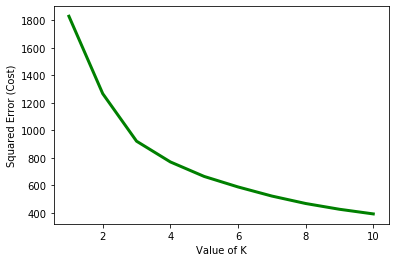

In [36]:
cost =[] 
for i in range(1, 11): 
    KM = KMeans(init="k-means++", n_clusters = i, n_init = 12) 
    KM.fit(cluster_dataset) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Squared Error (Cost)") 
plt.show()

According to the line chart above, the elbow point seems to be at K = 3.

I can now launch the K-Means Clustering's approach with an expected amount of cluster set to 3.

In [37]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 2 0 2 2 0 0 0 0 0 0 0 0
 0 1 0 1 2 2 0 0 0 0 0 0 1 1 0 0 0 0 0 2 2 2 0 2 0 0 0 0 1 0 1 2 2 2 2 1 0
 0 1 0 1 1 1 1 1 0 2 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 0 0 0 0 0 0 2
 2 2 2 0 1 0 0 0 0 1 2 2 1 0 0 0 0 0 0 0 2 2 2 2 1 1 0 0 0 0 0 0 0 0 0 0 2
 2 2 2 1 0 0 1 1 0 0 0 0 1 2 0 2 0 0 1 0 0 0 0 0 2 2 2 2 2 2 2 2 2 0 0 0 1
 1 1 1 0 1 0 0 0 0 2 2 2 2 1 1 2 2 2 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 1 1 1 0
 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 0 0 1 1 0 0 0 0 0 0 0 1 1 2 2 1 1 2 0 0 0
 0 1 1 1 0 0 1 1 2 2 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 2 1 2 2 2 2 2 2 2 1 1
 1 1 1 1 0 0 1 1 1 2 2 2 2 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 2 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2 2 1 1 1 1 1 1 0 0 0 0 0 0 2 0 0 0 0 0 2 2
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 2 2 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0
 0 0 0 0 0 0 0 1 1 1 1 0 

Add the resulting labels to the DataFrame

In [38]:
df_centers["label"] = labels
df_centers_data_only["label"] = labels
df_centers

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


latitude  longitude  stations  transactions  avg_price  total_venues  \
0    48.837899   2.256708         1            19     8119.0            14   
1    48.841958   2.260547         1            87     9929.0             4   
2    48.843311   2.260547         1            66     9837.0             2   
3    48.844664   2.260547         2            63    10478.0             5   
4    48.846017   2.260547         1            73    10780.0             6   
..         ...        ...       ...           ...        ...           ...   
608  48.846017   2.410260         1            43     9779.0             4   
609  48.847370   2.410260         1            30    10346.0             5   
610  48.848723   2.410260         1            18    11836.0             5   
611  48.852781   2.410260         1            22     7756.0             8   
612  48.854134   2.410260         1            21     7837.0            12   

     label  
0        0  
1        0  
2        0  
3        0  
4        0  
..     ...  
608      0  
609      0  
610      0  
611      0  
612      0  

[610 rows x 7 columns]

In [40]:
colors = [
    'orange',
    'lightgreen',
    'lightblue',
]

Display all the potential locations with a specific color for each cluster

In [41]:
map_paris = folium.Map(location=paris_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_paris) #cartodbpositron cartodbdark_matter
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
for center in df_centers.values.tolist():
    folium.CircleMarker(center[0:2], radius=3, color=colors[int(center[-1])], fill=True, fill_color=colors[int(center[-1])], fill_opacity=1).add_to(map_paris)
map_paris

Let's compute the average value for each group to find what could be the best choice

In [42]:
df_centers_data_only = df_centers_data_only.groupby('label').mean()
df_centers_data_only

transactions     avg_price  total_venues
label                                          
0         53.290221   9633.529968     11.851735
1        112.417112  10815.064171     27.609626
2         41.867925  14942.330189     22.632075

According to the result above, the best possible value for money (it may depend on the stakeholder) seems to be the cluster #1 as it is where there are the biggest amount of transactions which means that it should be easy to buy or sell a house or an apartment there, and the biggest amount of venues nearby indicating that there are a lot of activities nearby, and all this for a middle average price.

In [44]:
chosenCluster = 1

Let's display only the potential locations of the chosen cluster

In [45]:
map_paris = folium.Map(location=paris_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_paris) #cartodbpositron cartodbdark_matter
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
for center in df_centers[df_centers["label"] == chosenCluster].values.tolist():
    folium.CircleMarker(center[0:2], radius=3, color=colors[int(center[-1])], fill=True, fill_color=colors[int(center[-1])], fill_opacity=1).add_to(map_paris)
map_paris

I will keep only the potential locations of the chosen cluster which allows reducing the total amount of potential locations to **187**.

In [46]:
df_centers_target = df_centers[df_centers["label"] == chosenCluster]
df_centers_target

latitude  longitude  stations  transactions  avg_price  total_venues  \
8    48.848723   2.264386         1           101    10759.0            16   
23   48.856840   2.275902         1           101    10923.0            28   
24   48.858193   2.275902         1           111    10886.0            26   
38   48.847370   2.283580         1            31    10018.0            46   
40   48.858193   2.283580         1           106    11576.0            24   
..         ...        ...       ...           ...        ...           ...   
538  48.839252   2.391066         1           101     9688.0            19   
542  48.851428   2.391066         1           121     9331.0            13   
575  48.864957   2.398743         1           108     8691.0            24   
576  48.866310   2.398743         1           102     8275.0            18   
577  48.867663   2.398743         1           120     8060.0            14   

     label  
8        1  
23       1  
24       1  
38       1  
40       1  
..     ...  
538      1  
542      1  
575      1  
576      1  
577      1  

[187 rows x 7 columns]

In [47]:
def get_address(row):
    url = 'https://nominatim.openstreetmap.org/reverse?format=jsonv2&lat={}&lon={}'.format(row["latitude"], row["longitude"])
    result = requests.get(url).json()
    return result["display_name"]

As the final step, let's retrieve the address of what I consider as the best locations.

In [48]:
df_centers_target['address'] = df_centers.apply(get_address, axis=1)
df_centers_target.to_csv("df_centers_target.csv")
df_centers_target

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


latitude  longitude  stations  transactions  avg_price  total_venues  \
8    48.848723   2.264386         1           101    10759.0            16   
23   48.856840   2.275902         1           101    10923.0            28   
24   48.858193   2.275902         1           111    10886.0            26   
38   48.847370   2.283580         1            31    10018.0            46   
40   48.858193   2.283580         1           106    11576.0            24   
..         ...        ...       ...           ...        ...           ...   
538  48.839252   2.391066         1           101     9688.0            19   
542  48.851428   2.391066         1           121     9331.0            13   
575  48.864957   2.398743         1           108     8691.0            24   
576  48.866310   2.398743         1           102     8275.0            18   
577  48.867663   2.398743         1           120     8060.0            14   

     label                                            address  
8        1  11, Rue Poussin, Hameau Boileau, Auteuil, 16e,...  
23       1  Paris Passy, Rue Talma, Muette, 16e, Paris, Îl...  
24       1  La Grande Épicerie, Rue de Passy, Muette, 16e,...  
38       1  Tour Beaugrenelle, Rue de l'Ingénieur Robert K...  
40       1  9b, Rue de Passy, Muette, 16e, Paris, Île-de-F...  
..     ...                                                ...  
538      1  15, Boulevard de Reuilly, Picpus, 12e, Paris, ...  
542      1  227, Boulevard Voltaire, Ste-Marguerite, 11e, ...  
575      1  Gambetta - sortie 1 - Mairie du 20ième (Hôpita...  
576      1  La Girafe et la Lune, Rue des Gâtines, Père-La...  
577      1  18, Rue de la Chine, Père-Lachaise, 20e, Paris...  

[187 rows x 8 columns]

To get rid of extra information in the address, I apply a function to clean it up

In [49]:
def cleanAddress(address):
    try:
        index = address.index(", Paris")
        return address[0:index]
    except:
        return address    

In [50]:
df_centers_target = pd.read_csv("df_centers_target.csv")
df_centers_target = df_centers_target[["latitude", "longitude", "stations", "transactions", "avg_price", "total_venues", "address"]]
df_centers_target["address"] = df_centers_target["address"].apply(cleanAddress)
df_centers_target

latitude  longitude  stations  transactions  avg_price  total_venues  \
0    48.848723   2.264386         1           101    10759.0            16   
1    48.856840   2.275902         1           101    10923.0            28   
2    48.858193   2.275902         1           111    10886.0            26   
3    48.847370   2.283580         1            31    10018.0            46   
4    48.858193   2.283580         1           106    11576.0            24   
..         ...        ...       ...           ...        ...           ...   
182  48.839252   2.391066         1           101     9688.0            19   
183  48.851428   2.391066         1           121     9331.0            13   
184  48.864957   2.398743         1           108     8691.0            24   
185  48.866310   2.398743         1           102     8275.0            18   
186  48.867663   2.398743         1           120     8060.0            14   

                                               address  
0        11, Rue Poussin, Hameau Boileau, Auteuil, 16e  
1                  Paris Passy, Rue Talma, Muette, 16e  
2        La Grande Épicerie, Rue de Passy, Muette, 16e  
3    Tour Beaugrenelle, Rue de l'Ingénieur Robert K...  
4                        9b, Rue de Passy, Muette, 16e  
..                                                 ...  
182              15, Boulevard de Reuilly, Picpus, 12e  
183       227, Boulevard Voltaire, Ste-Marguerite, 11e  
184  Gambetta - sortie 1 - Mairie du 20ième (Hôpita...  
185  La Girafe et la Lune, Rue des Gâtines, Père-La...  
186            18, Rue de la Chine, Père-Lachaise, 20e  

[187 rows x 7 columns]

Let's now, keep the 10 best locations with the lowest price and highest amount of venues.

In [51]:
df_centers_target_top = df_centers_target.sort_values(['avg_price','total_venues'],ascending=[True, False]).head(10)
df_centers_target_top

latitude  longitude  stations  transactions  avg_price  total_venues  \
186  48.867663   2.398743         1           120     8060.0            14   
185  48.866310   2.398743         1           102     8275.0            18   
96   48.894721   2.345000         1           170     8285.0            13   
118  48.890662   2.348839         1           167     8295.0            10   
121  48.894721   2.348839         1           131     8361.0            10   
116  48.886604   2.348839         1           156     8537.0            21   
119  48.892015   2.348839         1           160     8585.0            12   
11   48.843311   2.295096         1            92     8605.0            28   
117  48.887957   2.348839         1           166     8668.0            23   
184  48.864957   2.398743         1           108     8691.0            24   

                                               address  
186            18, Rue de la Chine, Père-Lachaise, 20e  
185  La Girafe et la Lune, Rue des Gâtines, Père-La...  
96   Versigny Immobilier, Rue Versigny, Château Rou...  
118  Le Pain en Fêtes, Rue Marcadet, Château Rouge,...  
121  Théâtre de l'Alambic Comédie, Passage Kracher,...  
116                    86, Rue Myrha, Goutte-d'Or, 18e  
119  109, Rue de Clignancourt, Château Rouge, Clign...  
11          100, Rue de la Croix Nivert, Grenelle, 15e  
117   8, Rue Custine, Château Rouge, Clignancourt, 18e  
184  Gambetta - sortie 1 - Mairie du 20ième (Hôpita...

We can now display the best locations on the map of Paris

In [52]:
map_paris = folium.Map(location=paris_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_paris) #cartodbpositron cartodbdark_matter
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
for i, row in df_centers_target_top.iterrows():
    folium.CircleMarker([row["latitude"], row["longitude"]], popup="<b>Price:</b><br><i>{}€/sm</i><br><b>Total Venues:</b><br><i>{}</i><br><b>Address:</b><br><i>{}</i>".format(row["avg_price"], row["total_venues"], row["address"]).replace("'", "&#39;"), radius=3, color=colors[int(center[-1])], fill=True, fill_color=colors[int(center[-1])], fill_opacity=1).add_to(map_paris)
map_paris

## Results and Discussion 

In the final result, over the 10 proposals, there are 6 locations in the 18th boroughs and 3 locations in the 20th boroughs, which means that 90% of the proposals are in two boroughs, which is actually not really surprising since they are both well-known boroughs for all the activities that you can find there for a relatively cheap price.

Even if those locations are indeed nice place to live, there is still something that has not been considered in this project which is the crime rate due to lack of data. Indeed the north/northeast part of Paris has the highest crime rate ([more details about the crime rate in this report](https://www.lagazettedescommunes.com/telechargements/2019/06/etude-de-londrp-la-criminalit-sur-les-teritoires-du-grand-paris.pdf)) which is probably the reason why I finally end up with those locations, if the crime rate could have been taken into account I would probably have had a different result.

Another thing to consider is the different choices that I made throughout this project that could be considered more or less objectives, those choices allowed to get those particular locations but a stakeholder could have made different choices so we would have ended up with totally different results.

## Conclusion

The purpose of this project was to find the best places to live in Paris close to at least one subway station and close to as many activities as possible for a minimum price. Thanks to the different choices I made, I ended up with 10 best places to live but I realized that the places I found where not necessarily safe places. Due to a lack of data, I could not add the total amount of crimes as a feature to consider when clustering the potential locations, I would have chosen the cluster with the biggest possible amount of transactions and venues and with the lowest possible price and amount of crimes, the result would then have been very different.

To conclude, I would say that it is important to always have all the required data and a clear idea of what the stakeholder wants to make sure that we get the best possible results.